In [59]:
import matplotlib as mpl
import matplotlib.pyplot as plot

%matplotlib inline
mpl.rcParams['figure.dpi'] = 125

Machine Learning 101
===========

KharkivPy #17<br>
November 25th, 2017

by Roman Podoliaka, Software Engineer at DataRobot

twitter: <a href="https://twitter.com/rpodoliaka">@rpodoliaka</a><br>
email: <a href="mailto:roman.podoliaka@gmail.com">roman.podoliaka@gmail.com</a><br>
blog: http://podoliaka.org<br>
slides: http://podoliaka.org/talks/

## Goal

Take a close look at one of the simplest machine learning algorithms - *logistic regression* - to understand how it works internally and how it can be applied for the task of image classification.

... and, hopefully, dispel at least some hype around machine learning. 

## Problem

Create an algorithm (also called a **model**) to classify whether images contain either a *dog* or a *cat*.

<img src="catsvsdogs.jpg" style="width:30%; display: block; margin-left: auto; margin-right: auto;">

Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats

There are much better algorithms for this task, but we'll stick to logistic regression *for the sake of simplicity*.

## Input data

25000 **labeled** examples of JPEG images (of **different sizes**) of cats and dogs, e.g.: *cat.0.jpg*, *cat.1.jpg*, ..., *dog.1.jpg*, *dog.2.jpg*...

<div id="images" style="text-align:center;">
<img src="train/cat.0.jpg" style="width:20%; display: inline-block; margin-left: auto; margin-right: auto;">
<img src="train/dog.2.jpg" style="width:20%; display: inline-block; margin-left: auto; margin-right: auto;">
</div>

## Terminology and notation

This task is an example of:

1) **supervised learning** problem (we are given training examples with "correct" answers, as opposed to unlabeled examples in **unsupervised learning**)

2) **binary classification** problem (the output is a categorical value denoting one of two classes - *0* or *1*, as opposed to **multiclass classification**, where there are more than two classes, or **regression**, where the output is a real number)

## Terminology and notation

Let a column vector $ x = [x_1, x_2, \ldots, x_n] $ represent a single training example, where $ x_1, x_2, \ldots, x_n $ are values of its **features**.

For the task of image classification it's very common to treat **pixels** of a given image as its features.

If we were to build a machine learning model for medical diagnosis, we would need to come up with a list of features, that would be suitable for that task (e.g. age, weight, height of a person, whether they have been vaccinated, etc).

## Terminology and notation

Each training example is also accompanied by a **true label** (i.e. the "correct" answer) - $ y $.

For a *binary* classification problem $ y \in \{0, 1\} $

For a regression problem (e.g. "How many kgs of noodles will we sell next month?") $ y \in \mathbb{R} $

In [60]:
import concurrent.futures
import enum
import multiprocessing
import os
import random
import sys

import numpy as np
from PIL import Image

In [61]:
class Category(enum.Enum):
    dog = 0
    cat = 1

In [62]:
def image_to_example(path, width=64, height=64):
    filename = os.path.basename(path)

    # normalize the input image, so that we only work with images of the same size
    with Image.open(path) as img:
        resized = img.resize((width, height))

    # encoding of string labels: "dog" -> 0, "cat" -> 1 
    y = Category[filename.split('.')[0]].value
    
    # RGB image is flattened into a one long column vector of floats,
    # that denote color intensity
    x = np.array(resized, dtype=np.float64) \
          .reshape(width * height * 3, 1) / 256.

    return x, y, path

In [63]:
# preprocessing of a given example
x, y, _ = image_to_example('train/cat.1.jpg')

In [64]:
# true label
y

1

In [65]:
# normalized example
x

array([[ 0.15625   ],
       [ 0.171875  ],
       [ 0.16796875],
       ..., 
       [ 0.140625  ],
       [ 0.08984375],
       [ 0.06640625]])

In [66]:
# feature-vector dimensions
x.shape

(12288, 1)

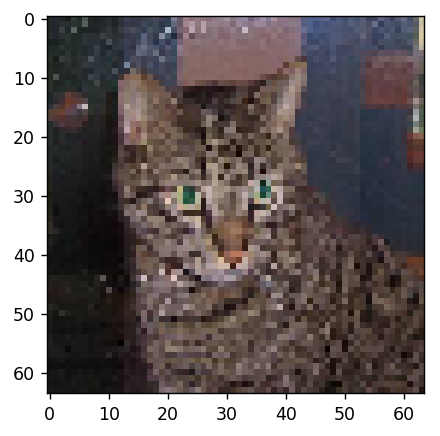

In [67]:
# restored image
plot.imshow(x.reshape(64, 64, 3))

In [68]:
# load and preprocess images in parallel
def load_examples(path, width=64, height=64):
    concurrency = multiprocessing.cpu_count()
    
    with concurrent.futures.ThreadPoolExecutor(concurrency) as executor:
        images_futures = [
            executor.submit(
                image_to_example,
                os.path.join(path, name), width, height
            )
            for name in os.listdir(path)
        ]

        return [
            i.result()
            for i in concurrent.futures.as_completed(images_futures)
        ]

## Task

Using a training set of labeled examples of images of dogs and cats, come up with a definition of function $ \hat{y}(x) $, that would output the probability of the fact, that a **new** example (i.e. not seen by this model before) is an image of a cat.

How do we teach a computer to do that?

## Logistic regression: hypothesis

$$ z = w_1 x_1 + w_2 x_2 + \ldots + w_n x_n + b $$

$$ \hat{y} = \frac{1}{1 + e^{-z}} $$

where:
* $ w_1, w_2, \ldots w_n $ (**weights**) and $ b $ (**bias**) are *parameters* of the algorithm that are learned during training
* $ x_1, x_2, \ldots, x_n $ are **features** or a training/test example
* $ \hat{y} $ is the **logistic function**, that outputs **probability** that the given example belongs to class 1

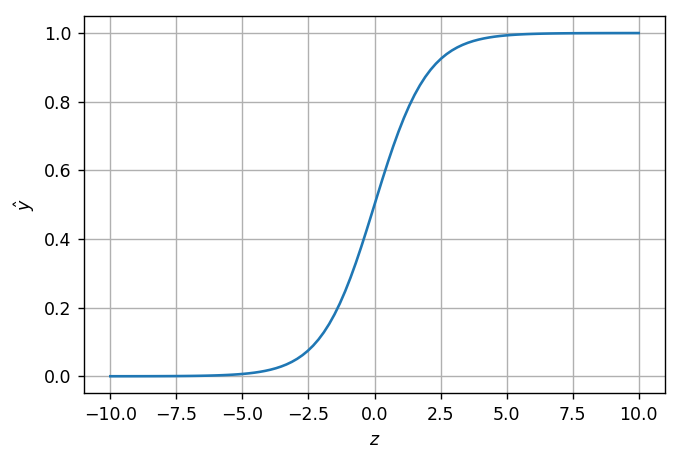

In [69]:
z = np.linspace(-10, 10, 100)
plot.xlabel('$ z $'), plot.ylabel('$ \hat{y} $')
plot.plot(z, 1 / (1 + np.exp(-z)))
plot.grid(True)

Note, that $ z $ is essentially a result of matrix multiplication of two column vectors of weights $ w $ and features $ x $ plus bias $ b $: 

$$ z = w_1 x_1 + w_2 x_2 + \ldots + w_n x_n + b = w^T x + b $$

Column vectors $ x $ of each example can also be stacked into a matrix (each computation can be performed in parallel):

$$
z =
w^T
\begin{bmatrix}
    x_{1}^{(1)} & x_{1}^{(2)} & \dots  & x_{1}^{(m)} \\
    x_{2}^{(1)} & x_{2}^{(2)} & \dots  & x_{2}^{(m)} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{n}^{(1)} & x_{n}^{(2)} & \dots  & x_{n}^{(m)}
\end{bmatrix} = \\
= [(w^T x^{(1)} + b), (w^T x^{(2)} + b), \ldots, (w^T x^{(m)} + b)]
$$

In [70]:
v1 = np.random.rand(10000, 1)
v2 = np.random.rand(10000, 1)

# computation happens in Python interpreter
%timeit sum(a * b for a, b in zip(v1, v2))

# computation happens in numpy
%timeit np.dot(v1.T, v2)

12.2 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.87 µs ± 76.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [71]:
def initialize_weights(n):
    # the simplest way is to initialize to zeros, but random
    # initialization is also ok
    
    w = np.zeros((n, 1))
    b = 0.0

    return w, b

In [72]:
def hypothesis(w, b, x):
    z = np.dot(w.T, x) + b

    return 1. / (1. + np.exp(-z))

## Logistic regression: training

**Training** is a process of finding such values of model parameters $ w $ and $ b $, which give the best **performance** on the training set.

But how do we measure performance?

## Logistic regression: cost function

**Cost function** is a measure of how close model predictions $ \hat{y} $ are to true labels $ y $:  

$$ J(w, b) = - \frac{1}{m} \sum_{i=1}^{m} \big( y_i \ln{\hat{y_i}} + (1 - y_i) \ln{(1 - \hat{y_i})} \big) $$

There are many different cost functions for ML algorithms, this one is called **logistic loss**.

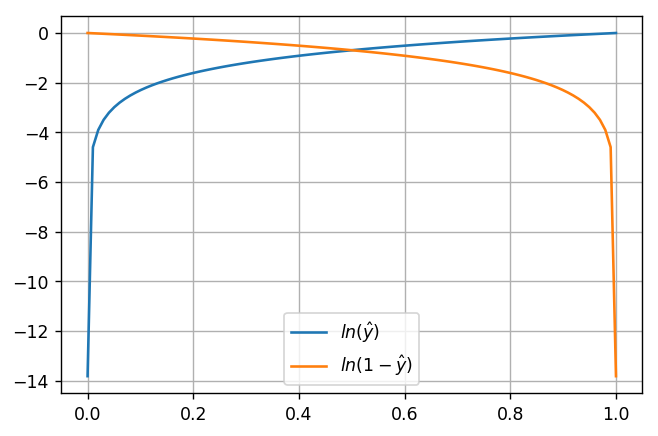

In [82]:
y_h = np.linspace(0.000001, 0.999999, 100)
plot.plot(y_h, np.log(y_h)), plot.plot(y_h, np.log(1 - y_h))
plot.legend(['$ ln(\hat{y}) $', '$ ln(1 - \hat{y}) $'])
plot.grid(True)

In [83]:
def cost(w, b, x, y):
    m = x.shape[1]
    y_h = hypothesis(w, b, x)

    return - np.sum(y * np.log(y_h) + (1 - y) * np.log(1 - y_h)) / m

## Logistic regression: gradient descent

**Gradient descent** is an iterative function optimization algorithm, that takes steps proportional to the negative of the *gradient* to find the local minimum:

$$ w^{i + 1} = w^{i} - \alpha \frac{\partial J}{\partial w} $$

$$ b^{i + 1} = b^{i} - \alpha \frac{\partial J}{\partial b} $$

where:

* $ \alpha $ - is a *hyperparameter* called **learning rate**, which effectively defines the size of gradient descent steps

## Gradient descent

<img src="gradient.svg" style="width:500px; display: block; margin-left: auto; margin-right: auto;">

## Logistic regression: gradient descent

$$ 
   \frac{\partial J}{\partial z} = \frac{\partial J}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z} =
       \hat{y} - y 
$$

$$ 
   \frac{\partial J}{\partial w} =
       \frac{\partial J}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z} \frac{\partial z}{\partial w} =
           \frac{1}{m} X (\hat{y} - y)^T
$$

$$
   \frac{\partial J}{\partial b} =
       \frac{\partial J}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z} \frac{\partial z}{\partial b} =
           \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)
$$

The process of changing the weights is sometimes called **backward propagation of errors** (as we use the difference between predictions $ \hat{y} $ and true labels $ y $ in order to modify the weights of inputs).

In [75]:
def update_weights(w, b, x, y_h, y, learning_rate):
    m = x.shape[1]

    # calculate the values of partial derivatives
    dz = y_h - y
    dw = np.dot(x, dz.T) / m
    db = np.sum(dz) / m

    # update the weights for the next iteration
    w = w - learning_rate * dw
    b = b - learning_rate * db

    return w, b

In [76]:
def logistic_regression(train_set, learning_rate=0.001, iterations=100, batch_size=64, callback=None):
    # stack training examples as columns into a (n, m) matrix
    x = np.column_stack(x[0] for x in train_set)
    y = np.array([x[1] for x in train_set], dtype=np.float64).reshape(1, len(train_set))

    # split the whole training set into batches of equal size
    n, m = x.shape
    num_batches = m // batch_size + (1 if m % batch_size > 0 else 0)
    x_batches = np.array_split(x, num_batches, axis=1)
    y_batches = np.array_split(y, num_batches, axis=1)

    # run the gradient descent to learn w and b
    w, b = initialize_weights(n)
    for iteration in range(iterations):
        j = 0

        for x_batch, y_batch in zip(x_batches, y_batches):
            y_hat = hypothesis(w, b, x_batch)
            w, b = update_weights(w, b, x_batch, y_hat, y_batch, learning_rate)

            j += cost(w, b, x_batch, y_batch) / num_batches

        if callback is not None:
            callback(iteration=iteration, w=w, b=b, cost=j)

    return w, b

## Model performance evaluation

It's important that we test the trained model on a separate set of examples it **has not seen before**, so that we ensure it generalizes well and does not **overfit** the training set.

Training and test set examples should come from the same distribution, so that the model is trained on the same kind of data it will be used to make predictions on later.

The performance metric we will use is **accuracy**, i.e. the percentage of correct predictions on a given data set.

In [77]:
def predict(w, b, x, threshold=0.5):
    y_h = hypothesis(w, b, x)

    return y_h >= threshold

In [78]:
def accuracy(w, b, data):
    # stack examples as columns into a (n, m) matrix
    x = np.column_stack(x[0] for x in data)
    y = np.array([x[1] for x in data]).reshape(1, x.shape[1])

    # calculate the accuracy value as a percentage of correct predictions
    correct_predictions = np.count_nonzero((y == predict(w, b, x)))
    total_predictions = x.shape[1]

    return correct_predictions / total_predictions

In [85]:
def main(path, iterations=100, max_examples=25000, train_ratio=0.9):
    # load examples and make sure they are uniformly distributed
    examples = load_examples(path)
    random.shuffle(examples)

    # split all the examples into train and test sets
    m_train = int(max_examples * train_ratio)
    train_set = examples[:m_train]
    test_set = examples[m_train:]
    
    # monitor the progress of training
    def progress(iteration, cost, w, b):
        print('Iteration %d' % iteration)
        print('\tCost: %f' % cost)
        if iteration % 10 == 0:
            print('\tTrain set accuracy: %s' % accuracy(w, b, train_set))
            print('\tTest set accuracy: %s' % accuracy(w, b, test_set)) 

    # run the training process to learn model parameters
    w, b = logistic_regression(train_set, iterations=iterations, callback=progress)
    print('\tFinal train set accuracy: %s' % accuracy(w, b, train_set))
    print('\tFinal test set accuracy: %s' % accuracy(w, b, test_set)) 

In [86]:
main("train")

Iteration 0
	Cost: 0.671012
	Train set accuracy: 0.5730222222222222
	Test set accuracy: 0.5704
Iteration 1
	Cost: 0.661474
Iteration 2
	Cost: 0.657053
Iteration 3
	Cost: 0.654155
Iteration 4
	Cost: 0.651971
Iteration 5
	Cost: 0.650178
Iteration 6
	Cost: 0.648624
Iteration 7
	Cost: 0.647228
Iteration 8
	Cost: 0.645945
Iteration 9
	Cost: 0.644749
Iteration 10
	Cost: 0.643624
	Train set accuracy: 0.6156444444444444
	Test set accuracy: 0.6032
Iteration 11
	Cost: 0.642558
Iteration 12
	Cost: 0.641543
Iteration 13
	Cost: 0.640573
Iteration 14
	Cost: 0.639644
Iteration 15
	Cost: 0.638753
Iteration 16
	Cost: 0.637895
Iteration 17
	Cost: 0.637070
Iteration 18
	Cost: 0.636274
Iteration 19
	Cost: 0.635505
Iteration 20
	Cost: 0.634762
	Train set accuracy: 0.6285333333333334
	Test set accuracy: 0.6108
Iteration 21
	Cost: 0.634043
Iteration 22
	Cost: 0.633347
Iteration 23
	Cost: 0.632671
Iteration 24
	Cost: 0.632016
Iteration 25
	Cost: 0.631379
Iteration 26
	Cost: 0.630760
Iteration 27
	Cost: 0.6301

## Summary

* logistic regression is a basic model, that does not generalize well for this task and only achieves ~63% accuracy on the test set (e.g. the leader in this Kaggle competition achieved ~98.6%)

* there are more sophisticated ML algorithms like **convolutional neural networks**, that perform better at image classification tasks

* concepts like backward propagation of errors and gradient descent are used in other algorithms as well

## Summary (continued)

* we did not have to explain a computer how to distinguish a cat from a dog - we just had to show it a lot of labeled examples

* ML algorithms are generic - you can use the very same logistic regression implementation for many different problems - just provide a different data set!

## Links

Andrew Ng:

* Introduction to ML: https://www.coursera.org/learn/machine-learning

* Deep Learning specialization: https://www.coursera.org/specializations/deep-learning

Machine Learning and Data Analysis specialization (Yandex):

* https://www.coursera.org/specializations/machine-learning-data-analysis

## Thanks!

<img src="questions.jpg" style="width:300px; display: block; margin-left: auto; margin-right: auto;">

twitter: <a href="https://twitter.com/rpodoliaka">@rpodoliaka</a><br>
email: <a href="mailto:roman.podoliaka@gmail.com">roman.podoliaka@gmail.com</a><br>
blog: http://podoliaka.org<br>
slides: http://podoliaka.org/talks/